## Identifying and plotting genes which have correlated spatial/buildup scores

Correlating using the reads directly from the .bam

In [1]:
import importlib
import pandas as pd
import numpy as np
import scipy.stats
from statsmodels.stats import multitest
import pysam
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import math
import glob
import os

import SRRS
from SRRS import plotting, utils
import importlib

## ReadZs scores for gene 3' UTRs

1. Specifying BAM path to get ReadZs scores from
2. Processing GTF to get 3' UTR positions
3. Matching gene names from MERFISH to the GTF to subset to just the regions of interest
4. Creating a table of ReadZs scores per ontology for each locus

In [2]:
%%time
#creating subsetted gtf to prepare for ReadZs score extraction

#this bam is from BICCN_10Xv3 has cell-type and sample of origin information as XO and RG tags respectively
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'
    
#mouse gtf file to be able to plot exons/introns/UTRs
full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/gencode.vM23.annotation.gtf',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','end','dot1','strand','dot2','info'],
)
gtf = full_gtf[full_gtf['kind'].isin(['exon','UTR'])]
gtf['label'] = gtf['info'].str.extract('gene_name "(.*?)";')
gtf['group'] = gtf['info'].str.extract('transcript_id "(.*?)";')

#Fam19a2 gene synonym Tafa2 is used in the gtf. changing it to match the gene/cell table
#Fam84b gene synonym Lratd2 is used in the gtf. changing it to match the gene/cell table
gtf.loc[gtf['label'].eq('Tafa2'),'label'] = 'Fam19a2'
gtf.loc[gtf['label'].eq('Lratd2'),'label'] = 'Fam84b'

#Get the MERFISH gene names from the gene_ont outputs
gene_ont_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*')
BICCN_genes_df = pd.concat((pd.read_csv(p, usecols=['gene']) for p in gene_ont_paths), ignore_index=True)
BICCN_genes = set(BICCN_genes_df['gene'])

#sanity checking gene labels match between GTF and spatial
#Determine how many genes are present in both the gtf and the gene/cell table
gtf_genes = set(gtf['label'])
shared_genes = BICCN_genes.intersection(gtf_genes)
BICCN_only_genes = BICCN_genes.difference(gtf_genes)

print('There are',len(gtf_genes),'unique genes in the gtf')
print('There are',len(BICCN_genes),'unique genes in the gene/cell table')
print('There are',len(shared_genes),'genes shared between both')
print('Genes present only in the gene/cell table',BICCN_only_genes)

#subset the gtf to just the entries with the shared genes
gtf = gtf[gtf['label'].isin(shared_genes)]

#have to 'manually' distinguish between 5' and 3' UTRs
for (transcript_id,strand),t in gtf.groupby(['group','strand']):
    if strand == '+':
        utr3_start = t[t['kind'].eq('exon')]['end'].max()
        utr_3s = t[t['kind'].eq('UTR') & t['end'].ge(utr3_start)]
    elif strand == '-':
        utr3_start = t[t['kind'].eq('exon')]['start'].min()
        utr_3s = t[t['kind'].eq('UTR') & t['start'].le(utr3_start)]
    else:
        sys.stderr.write('strand error\n')
        break
        
    gtf.loc[utr_3s.index,'kind'] = '3UTR'


#Determine which loci to plot by:
#1) selecting genes that are in both the gtf and the gene/cell table
#2) selecting on UTRs
#3) grouping by gene and expanding left to the 5'-most UTR start, and right to the 3'-most UTR end
#   this is important for genes with multiple annotated 3' UTRs
#4) add a bit of "padding" on either side of the locus as 1% of the span
loci = gtf[
    gtf['label'].isin(shared_genes) &
    gtf['kind'].eq('3UTR')
][['label','chrom','start','end','strand']].drop_duplicates()

loci = loci.groupby(['label','chrom','strand']).agg(
    start = ('start','min'),
    end = ('end','max'),
).reset_index()

padding = loci['end'].subtract(loci['start']).multiply(0.01).astype(int)
loci['start'] -= padding
loci['end'] += padding

print('There are',len(loci),'loci to use for plotting')

There are 55228 unique genes in the gtf
There are 252 unique genes in the gene/cell table
There are 242 genes shared between both
Genes present only in the gene/cell table {'Blank-1', 'Blank-10', 'Blank-2', 'Blank-4', 'Blank-6', 'Blank-9', 'Blank-7', 'Blank-3', 'Blank-8', 'Blank-5'}
There are 241 loci to use for plotting
CPU times: user 12.5 s, sys: 788 ms, total: 13.3 s
Wall time: 13.3 s


In [3]:
%%time
importlib.reload(utils)

#perform the ReadZs proxy scoring for each locus of interest for each ontology
data = collections.defaultdict(list)

for _,l in loci.iterrows():
    readzs_scores = utils.readzs_proxy_score(
        bam_path,
        locus = (l.chrom, l.start, l.end),
        strand = l.strand, #select only reads on this specific strand
        stratify_tag = 'XO',
        min_tag_reads = 100, #require at least x reads for an ontology to be included (over any number of cells)
    )

    for ontology,readzs_proxy in readzs_scores.items():
        data['gene'].append(l.label)
        data['ontology'].append(ontology)
        data['locus'].append((l.chrom,l.start,l.end,l.strand))
        data['chrom'].append(l.chrom)
        data['start'].append(l.start)
        data['end'].append(l.end)
        data['strand'].append(l.strand)
        data['readzs_proxy'].append(readzs_proxy)
    
median_readzs_scores = pd.DataFrame(data)
median_readzs_scores.head()

CPU times: user 40.7 s, sys: 699 ms, total: 41.4 s
Wall time: 1min 19s


,gene,ontology,locus,chrom,start,end,strand,readzs_proxy
0,1700022I11Rik,L23_IT,"(chr4, 42974124, 42983734, +)",chr4,42974124,42983734,+,0.282206
1,1700022I11Rik,L56_NP,"(chr4, 42974124, 42983734, +)",chr4,42974124,42983734,+,0.252237
2,1700022I11Rik,L5_IT,"(chr4, 42974124, 42983734, +)",chr4,42974124,42983734,+,0.254527
3,1700022I11Rik,L6_CT,"(chr4, 42974124, 42983734, +)",chr4,42974124,42983734,+,0.286264
4,1700022I11Rik,L6_IT,"(chr4, 42974124, 42983734, +)",chr4,42974124,42983734,+,0.285432


In [4]:
#write out so subsequent analysis can be done by just reading in this file
median_readzs_scores.to_csv(
    '../../nf_pipeline/outputs/BICCN_20220601_direct/BICCN_10XscRNAseq_readzs_proxies.csv',
    index=False,
)

# Correlate median Readzs proxy values to median spatial scores

Correct for multiple testing over all metrics (conservative?)

In [5]:
%%time
#read in all gene/ont info for both mice over all metrics
all_BICCN_gene_onts = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*.csv')
gene_ont_df = pd.concat((pd.read_csv(p) for p in all_BICCN_gene_onts))

data = collections.defaultdict(list)

for (gene,metric),sg in gene_ont_df.groupby(['gene','metric']):
           
    sg = sg.groupby('annotation')['med_score'].median().reset_index() #averaging over both mice

    readzs_df = median_readzs_scores[median_readzs_scores['gene'].eq(gene)]
    
    for locus,rg in readzs_df.groupby('locus'):
    
        shared_onts = list(set(sg['annotation']).intersection(rg['ontology']))
    
        #skip spatial/read-buildup correlations that have fewer x shared ontologies
        if len(shared_onts) < 4:
            continue
    
        sg_scores = sg.set_index('annotation').loc[shared_onts,'med_score']
        rg_scores = rg.set_index('ontology').loc[shared_onts,'readzs_proxy']
        
        r,p = scipy.stats.pearsonr(sg_scores, rg_scores)
        
        data['gene'].append(gene)
        data['metric'].append(metric)
        data['locus'].append(locus)
        data['num_shared_onts'].append(len(shared_onts))
        data['span_spatial'].append(sg_scores.max()-sg_scores.min())
        data['span_readzs'].append(rg_scores.max()-rg_scores.min())
        data['r'].append(r)
        data['p'].append(p)
    
corr_df = pd.DataFrame(data).dropna() #some NaN's because an input array is constant to the Pearson corr

#BH multiple hypothesis testing
passes,adj_p,_,_ = multitest.multipletests(
    corr_df['p'],
    alpha = 0.05,
    method = 'fdr_bh',
)
corr_df['bh_p'] = adj_p
corr_df['significant'] = passes

corr_df.sort_values('p')

/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/dev_env/lib64/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


CPU times: user 4.55 s, sys: 5.94 ms, total: 4.56 s
Wall time: 4.65 s


,gene,metric,locus,num_shared_onts,span_spatial,span_readzs,r,p,bh_p,significant
116,Chn2,puncta,"(chr6, 54219604, 54302623, +)",13,0.697000,0.541611,-0.962262,1.472044e-07,0.000099,True
667,Wipf3,periph,"(chr6, 54500987, 54503795, +)",12,0.333417,0.019943,0.964191,4.366431e-07,0.000146,True
669,Wipf3,radial,"(chr6, 54500987, 54503795, +)",12,0.569500,0.019943,0.960406,7.170293e-07,0.000160,True
666,Wipf3,central,"(chr6, 54500987, 54503795, +)",12,0.271332,0.019943,-0.948651,2.578554e-06,0.000357,True
115,Chn2,periph,"(chr6, 54219604, 54302623, +)",14,0.422103,0.541611,0.922398,2.663079e-06,0.000357,True
...,...,...,...,...,...,...,...,...,...,...
404,Plcxd3,puncta,"(chr15, 4574869, 4575559, +)",8,0.159000,0.037681,0.008287,9.844617e-01,0.990374,False
662,Vwc2,central,"(chr11, 11261444, 11269005, +)",9,0.116295,0.032403,0.004934,9.899495e-01,0.993956,False
126,Col15a1,central,"(chr4, 47312280, 47313175, +)",6,0.115007,0.060335,0.006007,9.909889e-01,0.993956,False
127,Col15a1,periph,"(chr4, 47312280, 47313175, +)",6,0.100662,0.060335,0.003200,9.951996e-01,0.996687,False


In [6]:
%%time
#Measure how different the ReadZs buildups are for the significant gene/loci to prioritize those genes
#using variance between ontologies as the measure, but I don't know if this is normalized for different numbers of 
#ontologies or different sized windows
gene_locus_var = {}

for _,r in corr_df[corr_df['significant']].iterrows():
    chrom,start,end,strand = r.locus
    read_pos_df = utils.bam_read_positions(
        bam_path,
        locus = (chrom, start, end),
        strand = strand,
        stratify_tag = 'XO',
        min_tag_reads = 100, #require at least x reads for an ontology to be included (over any number of cells)
    )

    #Bin the read_pos_df
    min_pos,max_pos = read_pos_df['pos'].min(),read_pos_df['pos'].max()
    span = max_pos-min_pos
    num_windows = min(span,100)
    bin_size = math.ceil(span/num_windows)
    bins = np.arange(min_pos,max_pos+bin_size,bin_size)
    read_pos_df['bin'] = pd.cut(read_pos_df['pos'],bins=bins,labels=bins[:-1],right=False)

    #Calculate the CDFs using the bins
    read_bin_df = read_pos_df.groupby(['strat','bin'])['pos'].count().reset_index()
    wide_df = read_bin_df.pivot(
        index='bin',
        columns='strat',
        values='pos',
    )
    wide_df = wide_df.cumsum().div(wide_df.sum())
    
    #Find the avg variance over all bins
    cdf_var = wide_df.var(axis=1).sum()/num_windows
    gene_locus_var[(r.gene,r.locus)] = cdf_var

#Add a new column to the corr_df of the mean variances
gene_locus_var = pd.Series(gene_locus_var)
corr_df = corr_df.set_index(['gene','locus'])
corr_df['readzs_var'] = gene_locus_var
corr_df = corr_df.reset_index()
corr_df.sort_values('readzs_var',ascending=False)

CPU times: user 28.9 s, sys: 156 ms, total: 29 s
Wall time: 29.1 s


,gene,locus,metric,num_shared_onts,span_spatial,span_readzs,r,p,bh_p,significant,readzs_var
601,Timp3,"(chr10, 86345864, 86349542, +)",radial,11,0.411000,0.490484,-0.666029,0.025261,0.138062,False,0.011151
600,Timp3,"(chr10, 86345864, 86349542, +)",puncta,11,0.453500,0.490484,-0.484930,0.130579,0.326449,False,0.011151
599,Timp3,"(chr10, 86345864, 86349542, +)",periph,11,0.468613,0.490484,-0.836369,0.001333,0.019847,True,0.011151
598,Timp3,"(chr10, 86345864, 86349542, +)",central,11,0.333662,0.490484,0.751451,0.007667,0.068491,False,0.011151
117,Chn2,"(chr6, 54219604, 54302623, +)",radial,13,0.396000,0.541611,-0.804837,0.000905,0.015400,True,0.007183
...,...,...,...,...,...,...,...,...,...,...,...
661,Vwc2,"(chr11, 11261444, 11269005, +)",radial,9,0.303000,0.032403,-0.055842,0.886534,0.936998,False,NaN
666,Wnt7b,"(chr15, 85535418, 85537410, -)",central,4,0.058786,0.003012,-0.140292,0.859708,0.922813,False,NaN
667,Wnt7b,"(chr15, 85535418, 85537410, -)",periph,4,0.043544,0.003012,-0.352421,0.647579,0.806464,False,NaN
668,Wnt7b,"(chr15, 85535418, 85537410, -)",puncta,4,0.117500,0.003012,-0.932302,0.067698,0.232806,False,NaN


In [7]:
corr_df[corr_df['significant']]['gene'].unique()

array(['Asic4', 'Camk2d', 'Cdh13', 'Chn2', 'Cxcl14', 'Dscaml1', 'Igfbp4',
       'Igfbp5', 'Marcksl1', 'Meis2', 'Nkain3', 'Nr2f2', 'Nr4a1', 'Nxph1',
       'Pcdh8', 'Prss23', 'Rgs6', 'Rnf152', 'Satb2', 'Shisa9', 'Slc30a3',
       'Slc32a1', 'Tbc1d4', 'Timp3', 'Trp53i11', 'Wipf3'], dtype=object)

# Plotting

In [8]:
#read in all gene/cell info for both mice over all metrics (this is a large table)
all_BICCN_gene_cells = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/*.csv')
gene_cell_df = pd.concat((
    pd.read_csv(p, usecols=['metric','annotation','gene','score'])
    for p in all_BICCN_gene_cells
))
gene_cell_df

,metric,annotation,gene,score
0,puncta,Endo,Cxcl14,-0.488000
1,puncta,Endo,Flt1,0.458000
2,puncta,Endo,Aqp4,-0.250000
3,puncta,Endo,Acta2,-0.848000
4,puncta,Endo,Timp3,0.566000
...,...,...,...,...
4669863,central,L5_IT,Tmem163,-0.303371
4669864,central,L5_IT,Tox,-0.198502
4669865,central,L5_IT,Trpc4,-0.820225
4669866,central,L5_IT,Wipf3,-0.033708


Making 61 plots
Timp3 chr10 86345864 86349542 +


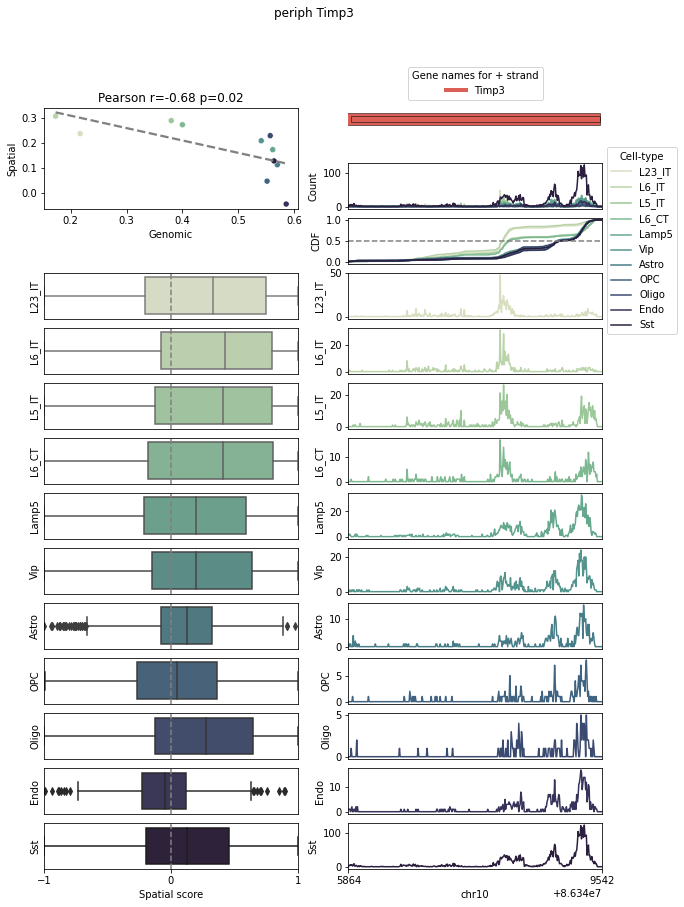

Chn2 chr6 54219604 54302623 +


KeyboardInterrupt: 

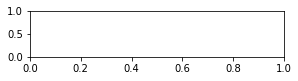

In [10]:
#Plotting
#Plot significant metric/gene combinations making buildup plots
importlib.reload(plotting)

plot_df = corr_df[
    corr_df['bh_p'].le(0.05)
].sort_values('readzs_var',ascending=False)

print('Making',len(plot_df),'plots')

pdf = plotting.make_pdf('BICCN_spatial_readzs_corrs_10Xv3.pdf')

for i,r in plot_df.iterrows():
    
    spatial_df = gene_cell_df[
        gene_cell_df['gene'].eq(r.gene)
        & gene_cell_df['metric'].eq(r.metric)
    ]

    chrom,start,end,strand = r.locus
    print(r.gene,chrom,start,end,strand)
    fig = plotting.read_buildup_plot(
        bam_path, locus=(chrom,start,end), strand=strand,
        ann_df=gtf, spatial_df=spatial_df,
        stratify_tag='XO', 
        ws=10, min_tag_reads=100,
    )
    
    my_suptitle = plt.suptitle(f'{r.metric} {r.gene}')
    pdf.savefig(fig, bbox_inches='tight', bbox_extra_artists=[my_suptitle])
    if r.gene == 'Timp3':
        plt.savefig('timp3.svg')
    plt.show(fig)
    plt.close()
    
pdf.close()

# SS2 bam

There is also SS2 scRNAseq data from the same BICCN project

I could do all of the above using the SS2 bam instead of the 10X bam

For now I'm just looking at Timp3



In [ ]:
#Trying the SS2 bam
#this bam is from BICCN_SS2 has cell-type and sample of origin information as XO and RG tags respectively
importlib.reload(plotting)
bam_path_SS2 = '../../inputs/BICCN_SS2v4_scRNAseq.bam'

gene = 'Timp3'
metric = 'periph'
chrom,start,end = ('chr10', 86345720, 86349686)

g = gene_cell_df[
    gene_cell_df['gene'].eq(gene)
    & gene_cell_df['metric'].eq(metric)
]

#note, no strand since SS2 is unstranded
fig = plotting.read_buildup_plot(
    bam_path_SS2, locus=(chrom,start,end),
    ann_df=gtf, spatial_df=g,
    stratify_tag='XO', 
    ws=50, min_tag_reads=100,
)
plt.show()
plt.close()